# Intro

В данном ноутбуке проверяются гипотезы статьи [Does Knowledge Distillation Really Work?](https://openreview.net/forum?id=Oa9RlXNggGy) в отличной от статьи модальности (а именно аудио-данные в задаче Key Word Spotting).

Код ниже базируется на коде с курса "Глубинное обучение в обработке звука": https://github.com/markovka17/dla/blob/2021/week06/seminar.ipynb

# Import and misc

In [1]:
!pip install torchaudio

In [1]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice, product
from copy import deepcopy

import random
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

In [2]:
SEED = 3407 # is all you need
def fix_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Задача и данные

Наша задача - **Key Word Spotting** (определение ключевого слоя). В простейшем сценарии это просто задача бинарной классификации над небольшими аудиозаписями (содержит данная аудиозапись ключевое слово или нет), но задачу можно усложнить на случай нескольких ключевых слов или на предсказании на потоковых данных. Здесь будет использоваться простой сценарий. 

In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'bird'  # We will use 1 key word -- 'bird'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-02-01 16:21:25--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.135.128, 2607:f8b0:400e:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.135.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  88.6MB/s    in 17s     

2022-02-01 16:21:42 (84.3 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [5]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [6]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [7]:
dataset.csv.sample(5)

,path,keyword,label
21020,speech_commands/tree/e53139ad_nohash_0.wav,tree,0
28847,speech_commands/up/c79159aa_nohash_1.wav,up,0
42575,speech_commands/nine/d486fb84_nohash_0.wav,nine,0
23342,speech_commands/right/b9f46737_nohash_3.wav,right,0
10987,speech_commands/go/e0a7c5a0_nohash_0.wav,go,0


### Augmentations

Будем пробовать с ними и без них

In [8]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [9]:
fix_seed(SEED)

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [10]:
# Сохраним на всякий случай (для воспроизводимости)
train_df.to_csv('train.csv')
val_df.to_csv('val.csv')

In [11]:
train_df = pd.read_csv('train.csv', index_col=0)
val_df = pd.read_csv('val.csv', index_col=0)

In [12]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df)
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [13]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [14]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [15]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [16]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [17]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [18]:
melspec_train = LogMelspec(is_train=False, config=TaskConfig)  # no aug
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [19]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [20]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Модель

Мы будем использовать модель **CRNN**, потому что она маленькая (актуально в нашей задаче в целом), быстро учится, но при этом довольно мощная (подробнее: https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [65]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int, return_attn=False):
        super().__init__()
        self.return_attn = return_attn

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        if self.return_attn:
            return (input * alpha).sum(dim=-2), alpha
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig, return_attn=False):
        super().__init__()
        self.config = config
        self.return_attn = return_attn

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        true_hidden = config.hidden_size * (2 if config.bidirectional else 1)
        self.attention = Attention(true_hidden, self.return_attn)
        self.classifier = nn.Linear(true_hidden, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        if self.return_attn:
            contex_vector, dist = self.attention(gru_output)
        else:
            contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)

        if self.return_attn:
            return output, dist
        return output

In [66]:
fix_seed(SEED)

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [23]:
def train_epoch(model, opt, loader, log_melspec, device):
    accs = []

    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        accs.append((torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)).item())

    return np.mean(accs)

In [24]:
@torch.no_grad()
def validation(model, loader, log_melspec, device, teacher=None):
    model.eval()

    val_losses, accs, agrees = [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )

        if teacher is not None:
            # fidelity
            teacher_logits = teacher(batch)
            teacher_pred = torch.argmax(teacher_logits, dim=-1)
            agrees.append(
                torch.sum(argmax_probs == teacher_pred).item() /
                torch.numel(argmax_probs)
            )

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    result = {
        'val_loss': np.mean(val_losses),
        'val_acc': np.mean(accs),
        'val_au_fa_fr': au_fa_fr
    }
    if teacher is not None:
        result['val_agreement'] = np.mean(agrees)
    return result

# Обучение базовой модели

In [25]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

def num_parameters(model):
    return sum([p.numel() for p in model.parameters()])

In [26]:
fix_seed(SEED)

config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [27]:
num_parameters(model)

70443

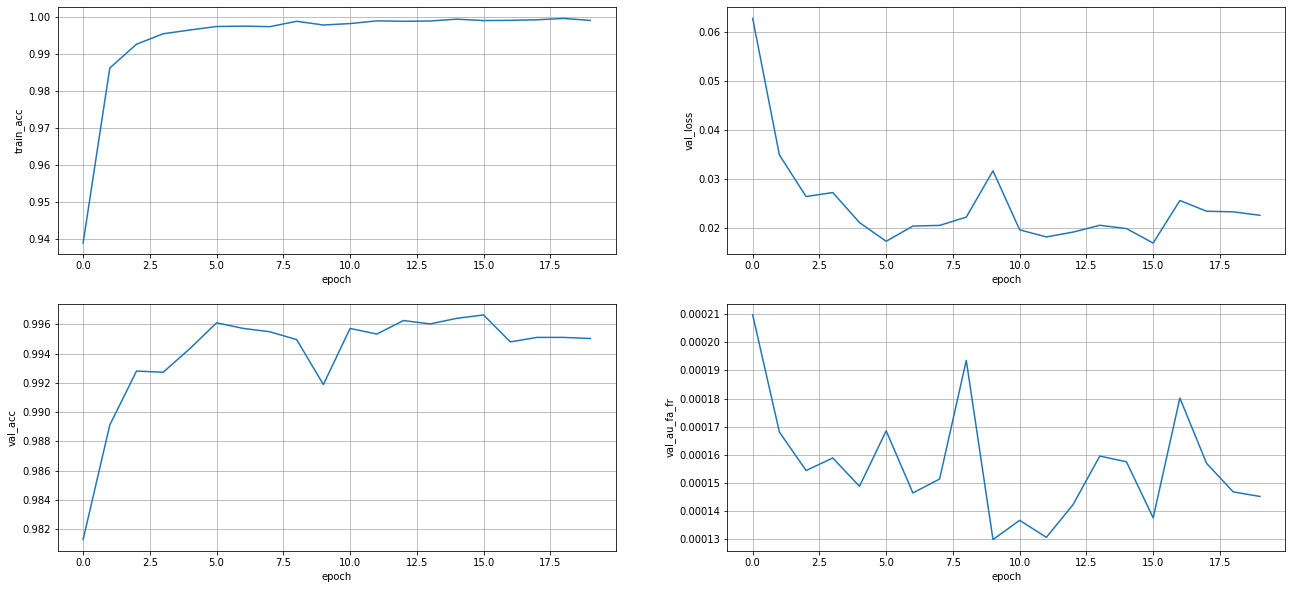

END OF EPOCH 20/20


In [134]:
# TRAIN
fix_seed(SEED)

history = {
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_au_fa_fr': []
}

for n in range(TaskConfig.num_epochs):

    train_acc = train_epoch(model, opt, train_loader, melspec_train, config.device)

    val_metrics = validation(model, val_loader, melspec_val, config.device)

    history['train_acc'].append(train_acc)
    for k, v in val_metrics.items():
        history[k].append(v)

    clear_output()

    fig, _ = plt.subplots(figsize=(22, 10))

    for i, metric_name in enumerate(history.keys()):
        ax = plt.subplot(2, 2, i + 1)
        ax.plot(history[metric_name])
        ax.set_ylabel(metric_name)
        ax.set_xlabel('epoch')
        ax.grid()
    
    plt.show()

    print(f"END OF EPOCH {n+1}/{TaskConfig.num_epochs}")

In [28]:
teacher0 = deepcopy(model)

In [137]:
torch.save(teacher0.state_dict(), 'teacher0.pt')

In [29]:
teacher0.load_state_dict(torch.load('teacher0.pt'))

<All keys matched successfully>

In [30]:
teacher0_metrics = validation(teacher0, val_loader, melspec_val, config.device)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:850: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:925.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
102it [00:06, 15.80it/s]


# Эксперимент 1. Self-distillation and temperature

В рамках этого эксперимента предлагается просто сдистиллировать модель в модель той же архитектуры, попутно изучая влияние температуры.

Важным здесь является то, что дистилляция "полная", то есть в функции потерь участвует только слагаемое, сравнивающее учителя и студента (без hard loss'а).

Здесь будет использована функция потерь как в статье:

$$
\mathcal{L}_s = \alpha \mathcal{L}_{hard} + (1 - \alpha) \mathcal{L}_{teacher} = \alpha CE(y, y_s; 1) + (1 - \alpha) \tau^2 CE(y_t, y_s; \tau)
$$
где $CE$ - стандартная кросс-энтропия с температурным шкалированием (логитов)

In [31]:
Ts = [1., 2., 4., 8.]
alpha = 0.0

In [32]:
def train_student_epoch(student, teacher, optimizer, loader, T=1.0, alpha=0.0):
    student.train()

    accs, agrees = [], []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(config.device), labels.to(config.device)
        batch = melspec_train(batch)

        optimizer.zero_grad()

        logits = student(batch)
        with torch.no_grad():
            teacher_probs = F.softmax(teacher(batch) / T, dim=-1)

        probs = F.softmax(logits, dim=-1)

        hard_loss = F.cross_entropy(logits, labels)
        soft_loss = F.cross_entropy(logits / T, teacher_probs)
        loss = alpha * hard_loss + (1 - alpha) * T * T * soft_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        optimizer.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        accs.append((torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)).item())
        agrees.append((torch.sum(argmax_probs == torch.argmax(teacher_probs, dim=-1)) / torch.numel(argmax_probs)).item())

    return {
        'train_acc': np.mean(accs),
        'train_agreement': np.mean(agrees)
    }

def train_student(student, teacher, optimizer, loader, n_epochs=TaskConfig.num_epochs, T=1.0, alpha=0.0, scheduler=None):
    teacher.eval()
    history = {
        'train_acc': [],
        'train_agreement' : [],
        'val_loss': [],
        'val_acc': [],
        'val_au_fa_fr': [],
        'val_agreement': []
    }

    for n in range(n_epochs):
        epoch_metrics = train_student_epoch(student, teacher, optimizer, loader, T, alpha)

        epoch_metrics.update(validation(student, val_loader, melspec_val, config.device, teacher))

        if scheduler is not None:
            scheduler.step()

        for k in history.keys():
            history[k].append(epoch_metrics[k])

        clear_output()
        fig, _ = plt.subplots(figsize=(22, 15))

        for i, metric_name in enumerate(['train_acc', 'train_agreement', 'val_acc', 'val_agreement', 'val_loss', 'val_au_fa_fr']):
            ax = plt.subplot(3, 2, i + 1)
            ax.plot(history[metric_name])
            ax.set_ylabel(metric_name)
            ax.set_xlabel('epoch')
            ax.grid()
        
        plt.show()

        print(f"END OF EPOCH {n+1}/{n_epochs}")
    
    return student, history

In [71]:
def sweep_students(student_config, teacher, Ts, alphas, save_fmt='student{}.pt', return_attn=False):
    history = []

    for i, (alpha, T) in enumerate(product(alphas, Ts)):
        print(f"student {i+1}/{len(Ts) * len(alphas)}")
        print(f"T={T}, alpha={alpha}")
        student = CRNN(student_config, return_attn=return_attn).to(config.device)
        optimizer = torch.optim.Adam(
            student.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )
        student, student_history = train_student(student, teacher, optimizer, train_loader, T=T, alpha=alpha)
        torch.save(student.state_dict(), save_fmt.format(i))
        history.append(student_history)

    return history


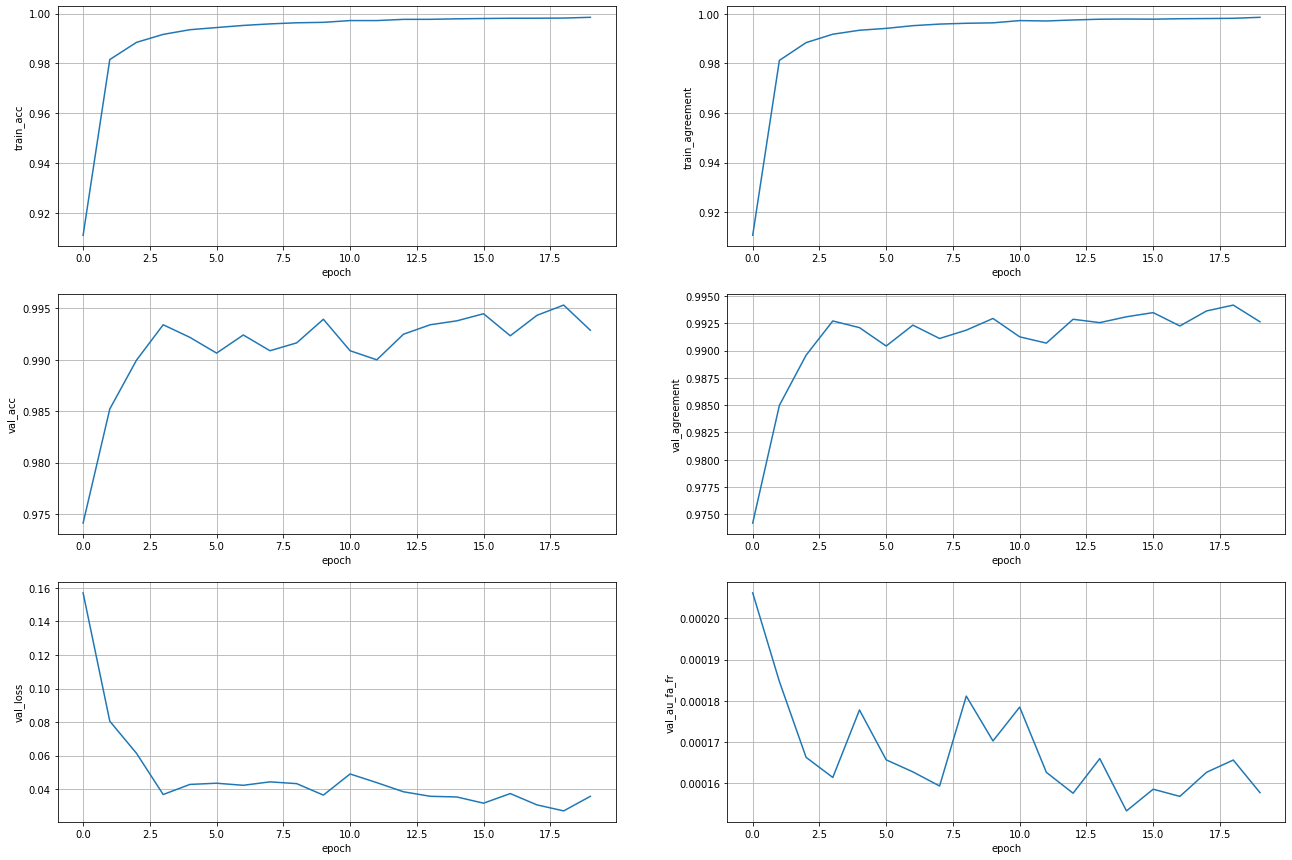

END OF EPOCH 20/20


In [143]:
fix_seed(SEED)

config = TaskConfig()
history = sweep_students(config, teacher0, Ts, [0.0], save_fmt='student_exp1_{}.pt')

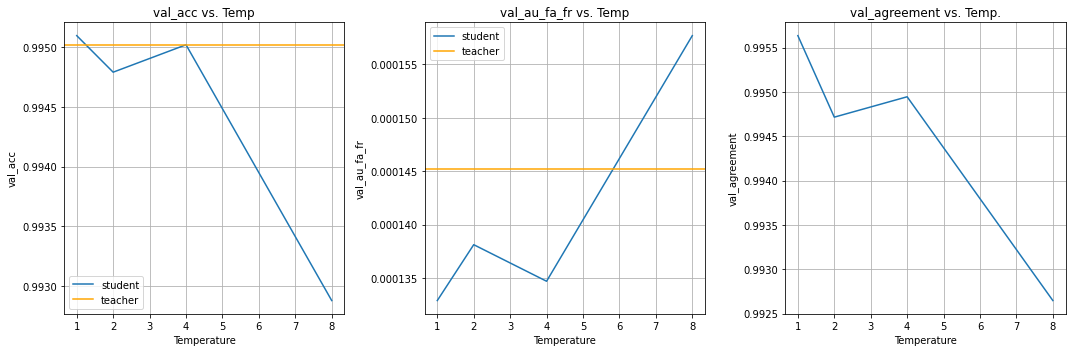

In [144]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

for i, name in enumerate(['val_acc', 'val_au_fa_fr']):
    axs[i].plot(Ts, [x[name][-1] for x in history], label='student')
    axs[i].axhline(teacher0_metrics[name], label='teacher', c='orange')
    axs[i].set_xlabel('Temperature')
    axs[i].set_ylabel(name)
    axs[i].set_title(name + ' vs. Temp')
    axs[i].legend()
    axs[i].grid()

axs[-1].plot(Ts, [x['val_agreement'][-1] for x in history], label='val_agreement')
axs[-1].set_xlabel('Temperature')
axs[-1].set_ylabel('val_agreement')
axs[-1].set_title('val_agreement vs. Temp.')
axs[-1].grid()

plt.tight_layout()
plt.show()

Какую-то явную зависимость проследить сложно, но видно, что качество студента коррелирует с согласованностью с учителем. В общем же согласованность с учителем довольно высокая.

Этот результат немного противоречит статье, в которой отмечается, что в сеттинге self-distillation обычно наблюдается обратное: качество студента выше качества учителя ценой более низкой согласованности.

In [34]:
import json

In [145]:
with open('exp1_metrics.json', 'w') as f:
    json.dump(history, f)

In [38]:
with open('exp1_metrics.json', 'r') as f:
    history1 = json.load(f)

# Эксперимент 2. Аугментации

В статье отмечается, что аугментации могут влиять согласованность с учителем, посмотрим на это в том же сеттинге.

Тут можно попробовать 2 варианта: сдистиллировать с модели обученной без аугментаций и с ними. Первый случай моделирует ситуацию, когда студент обучается на большем наборе данных, это можно поисследовать и сравнить с предыдущим. 

Второй вариант с предыдущими сравнить сложнее, но просто интересно как соотносится качество.

## 2.1 Teacher (no aug) -> Student (aug)

In [37]:
train_set_aug = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
train_loader = DataLoader(train_set_aug, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

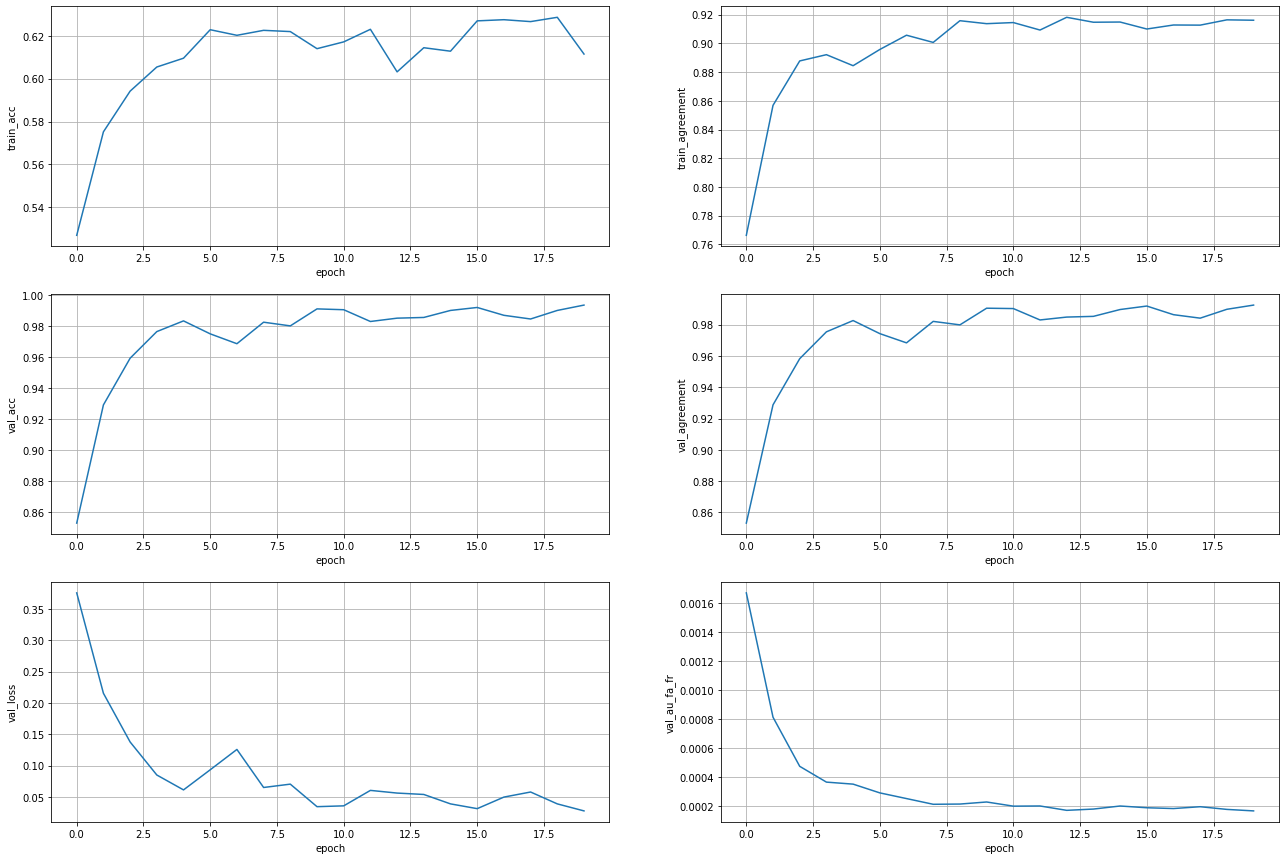

END OF EPOCH 20/20


In [147]:
fix_seed(SEED)

config = TaskConfig()
history = sweep_students(config, teacher0, Ts, [0.0], save_fmt='student_exp2-1_{}.pt')

In [157]:
with open('exp2-1_metrics.json', 'w') as f:
    json.dump(history, f)

In [39]:
with open('exp2-1_metrics.json', 'r') as f:
    history2_1 = json.load(f)

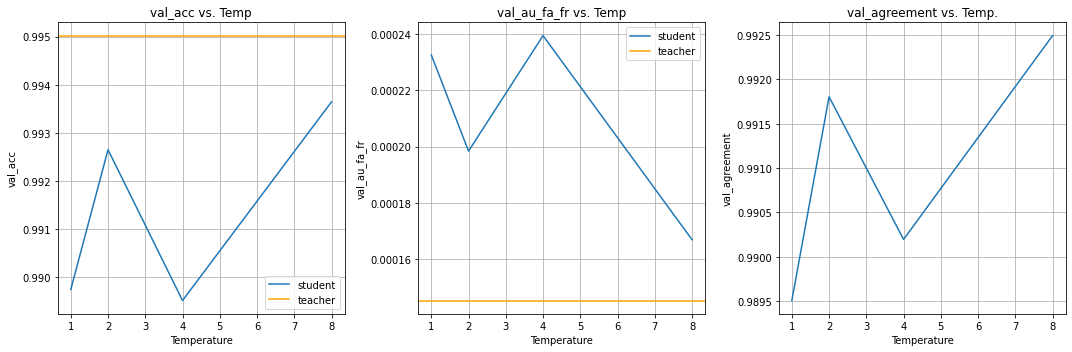

In [149]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

for i, name in enumerate(['val_acc', 'val_au_fa_fr']):
    axs[i].plot(Ts, [x[name][-1] for x in history2_1], label='student')
    axs[i].axhline(teacher0_metrics[name], label='teacher', c='orange')
    axs[i].set_xlabel('Temperature')
    axs[i].set_ylabel(name)
    axs[i].set_title(name + ' vs. Temp')
    axs[i].legend()
    axs[i].grid()

axs[-1].plot(Ts, [x['val_agreement'][-1] for x in history2_1], label='val_agreement')
axs[-1].set_xlabel('Temperature')
axs[-1].set_ylabel('val_agreement')
axs[-1].set_title('val_agreement vs. Temp.')
axs[-1].grid()

plt.tight_layout()
plt.show()

In [150]:
history2_1 = deepcopy(history)

In [161]:
with open('exp1_metrics.json', 'r') as f:
    history1 = json.load(f)

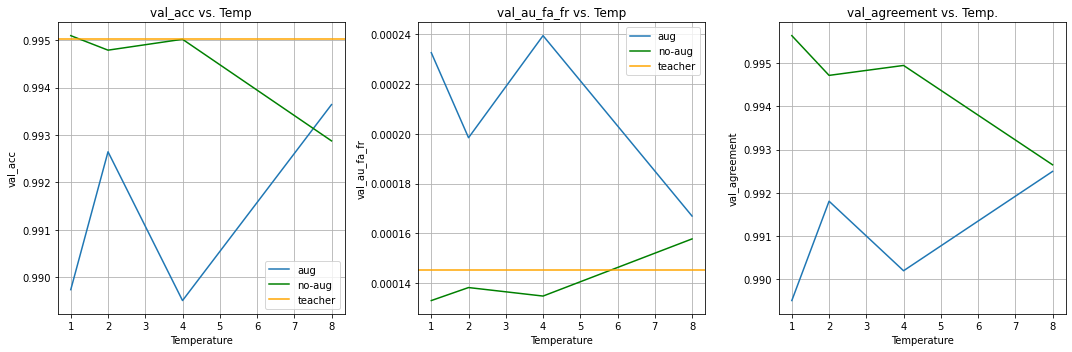

In [165]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

for i, name in enumerate(['val_acc', 'val_au_fa_fr']):
    axs[i].plot(Ts, [x[name][-1] for x in history2_1], label='aug')
    axs[i].plot(Ts, [x[name][-1] for x in history1], label='no-aug', c='g')
    axs[i].axhline(teacher0_metrics[name], label='teacher', c='orange')
    axs[i].set_xlabel('Temperature')
    axs[i].set_ylabel(name)
    axs[i].set_title(name + ' vs. Temp')
    axs[i].legend()
    axs[i].grid()

axs[-1].plot(Ts, [x['val_agreement'][-1] for x in history2_1], label='aug')
axs[-1].plot(Ts, [x['val_agreement'][-1] for x in history1], label='no-aug', c='g')
axs[-1].set_xlabel('Temperature')
axs[-1].set_ylabel('val_agreement')
axs[-1].set_title('val_agreement vs. Temp.')
axs[-1].grid()

plt.tight_layout()
plt.show()

Здесь снова противоречивые со статьей результаты. Студент без аугментаций учится лучше во всех смыслах (качество и согласованность с учителем), чем с аугментациями. Причем качество прямо зависит от согласованности (в статье в self-distillation сетапе наблюдается обратное)

## 2.2 Teacher (aug) -> Student (aug)

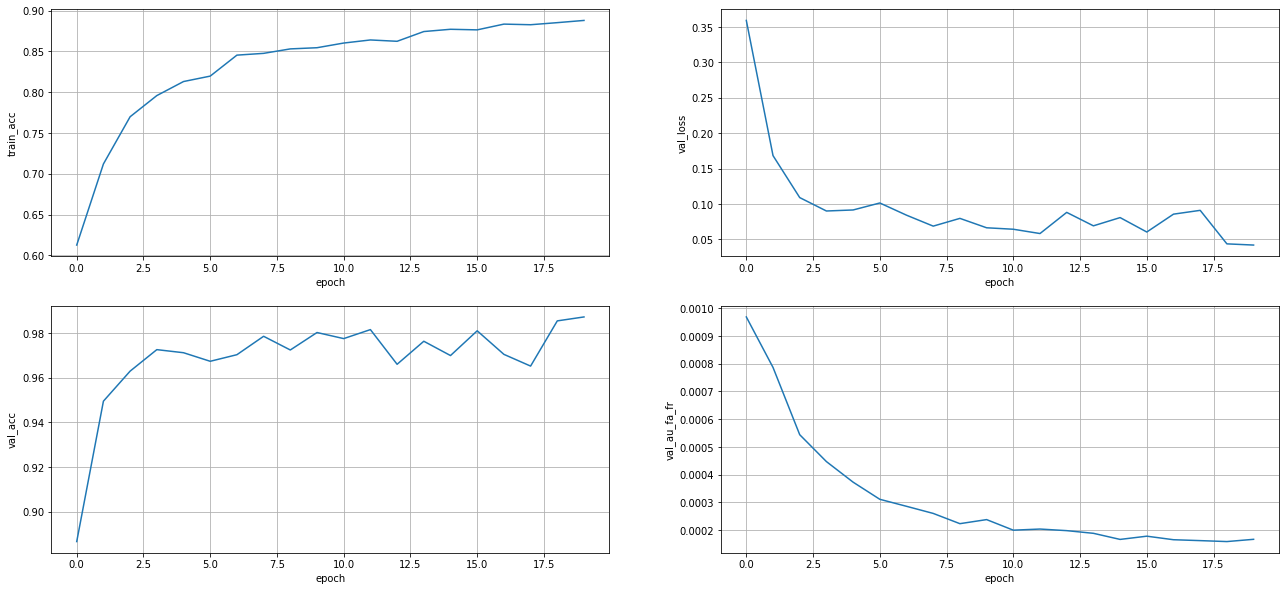

END OF EPOCH 20/20


In [151]:
fix_seed(SEED)

config = TaskConfig()
model = CRNN(config).to(config.device)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

history = {
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_au_fa_fr': []
}

for n in range(TaskConfig.num_epochs):

    train_acc = train_epoch(model, opt, train_loader, melspec_train, config.device)

    val_metrics = validation(model, val_loader, melspec_val, config.device)

    history['train_acc'].append(train_acc)
    for k, v in val_metrics.items():
        history[k].append(v)

    clear_output()

    fig, _ = plt.subplots(figsize=(22, 10))

    for i, metric_name in enumerate(history.keys()):
        ax = plt.subplot(2, 2, i + 1)
        ax.plot(history[metric_name])
        ax.set_ylabel(metric_name)
        ax.set_xlabel('epoch')
        ax.grid()
    
    plt.show()

    print(f"END OF EPOCH {n+1}/{TaskConfig.num_epochs}")

In [42]:
teacher1 = deepcopy(model)

In [153]:
torch.save(teacher1.state_dict(), 'teacher1.pt')

In [43]:
teacher1.load_state_dict(torch.load('teacher1.pt'))

<All keys matched successfully>

In [44]:
teacher1_metrics = validation(teacher1, val_loader, melspec_val, config.device)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:850: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:925.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
102it [00:05, 19.67it/s]




---



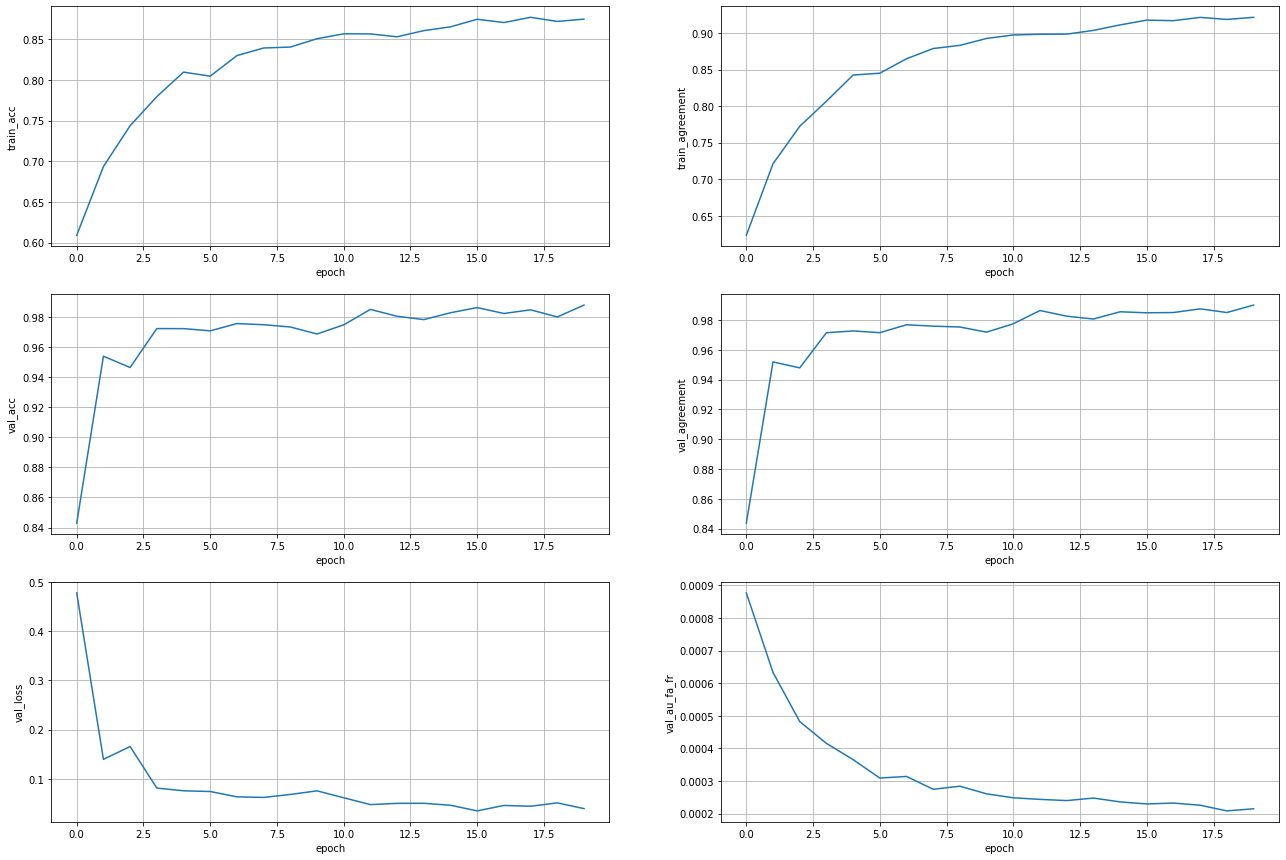

END OF EPOCH 20/20


In [158]:
fix_seed(SEED)

config = TaskConfig()
history2_2 = sweep_students(config, teacher1, Ts, [0.0], save_fmt='student_exp2-2_{}.pt')

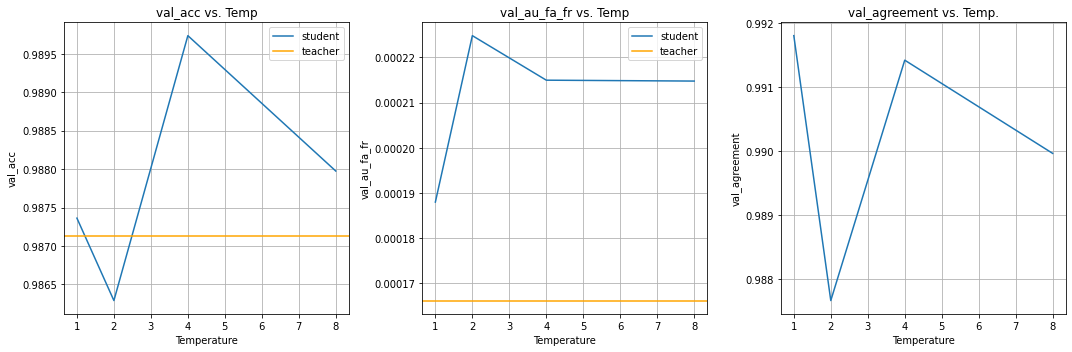

In [166]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

for i, name in enumerate(['val_acc', 'val_au_fa_fr']):
    axs[i].plot(Ts, [x[name][-1] for x in history2_2], label='student')
    axs[i].axhline(teacher1_metrics[name], label='teacher', c='orange')
    axs[i].set_xlabel('Temperature')
    axs[i].set_ylabel(name)
    axs[i].set_title(name + ' vs. Temp')
    axs[i].legend()
    axs[i].grid()

axs[-1].plot(Ts, [x['val_agreement'][-1] for x in history2_2], label='val_agreement')
axs[-1].set_xlabel('Temperature')
axs[-1].set_ylabel('val_agreement')
axs[-1].set_title('val_agreement vs. Temp.')
axs[-1].grid()

plt.tight_layout()
plt.show()

In [160]:
with open('exp2-2_metrics.json', 'w') as f:
    json.dump(history2_2, f)

In [45]:
with open('exp2-2_metrics.json', 'r') as f:
    history2_2 = json.load(f)

Здесь сложно сделать какие-то выводы, разве что в целом качество и согласованность ниже, чем в сетапе раньше; и теперь метрика не совсем прямо зависит от согласованности (особенно в случае AUC)

Но поскольку в основном в реальной жизни учитель учится с аугментациям далее за основного учителя выберем именно этот вариант.

# Эксперимент 3. Ансамбли

Другой сетап использования дистилляции: дистиллирование ансамбля в одну модель.

Попробуем воспроизвести зависимость качества и согласованности в зависимости от размера ансамбля (температуру примем равной 4, хотя это не особо аргументированно, но уже в нескольких статья я видел, что такое и рекомендуют)

In [55]:
class Ensemble(nn.Module):
    def __init__(self, teachers):
        super().__init__()
        self.teachers = nn.ModuleList(teachers)

    def forward(self, x):
        logits = torch.stack([model(x) for model in self.teachers], dim=1)
        logits = F.log_softmax(logits, dim=-1)
        logits = torch.logsumexp(logits, dim=1) - np.log(len(self.teachers))
        return logits

Обучим пять учителей с аугментациями на разных сидах.

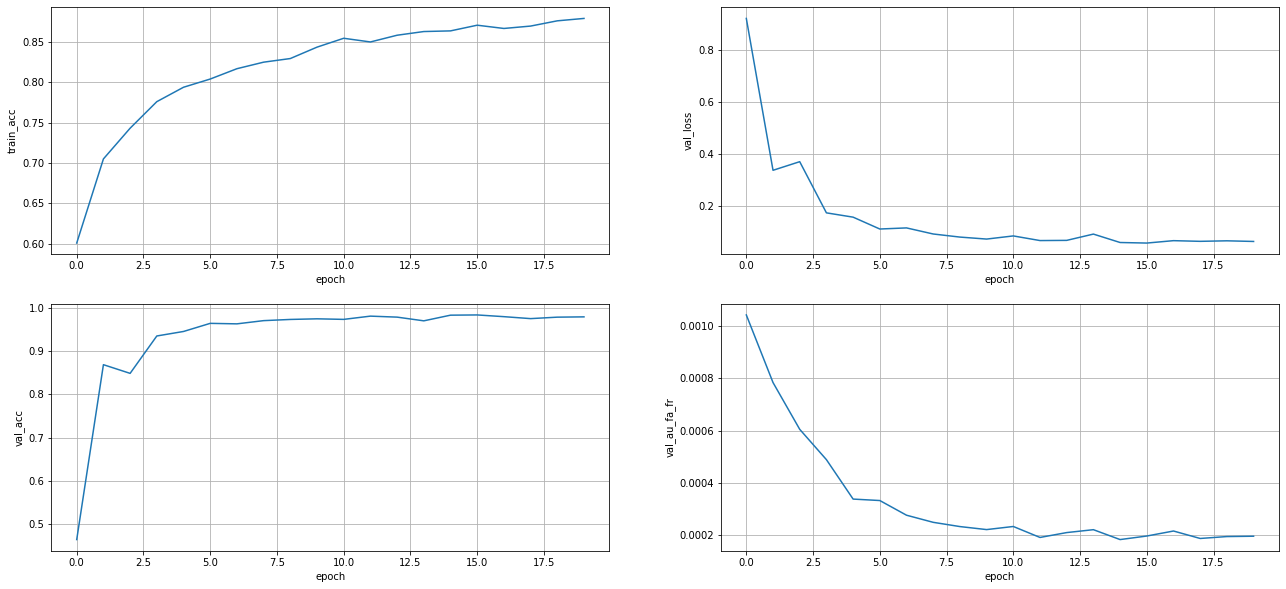

END OF EPOCH 20/20


In [48]:
ens_teachers = []

for teacher_id in range(5):
    print(f"Teacher {teacher_id}")
    fix_seed(SEED + i)

    config = TaskConfig()
    model = CRNN(config).to(config.device)

    opt = torch.optim.Adam(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )

    history = {
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_au_fa_fr': []
    }

    for n in range(TaskConfig.num_epochs):

        train_acc = train_epoch(model, opt, train_loader, melspec_train, config.device)

        val_metrics = validation(model, val_loader, melspec_val, config.device)

        history['train_acc'].append(train_acc)
        for k, v in val_metrics.items():
            history[k].append(v)

        clear_output()

        fig, _ = plt.subplots(figsize=(22, 10))

        for i, metric_name in enumerate(history.keys()):
            ax = plt.subplot(2, 2, i + 1)
            ax.plot(history[metric_name])
            ax.set_ylabel(metric_name)
            ax.set_xlabel('epoch')
            ax.grid()
        
        plt.show()

        print(f"END OF EPOCH {n+1}/{TaskConfig.num_epochs}")
    
    torch.save(model.state_dict(), f'teacher2_{teacher_id}.pt')
    ens_teachers.append(deepcopy(model))

In [56]:
ensemble0 = Ensemble(ens_teachers[:1])
ensemble1 = Ensemble(ens_teachers[:3])
ensemble2 = Ensemble(ens_teachers)

Теперь сдистиллируем в одну модель

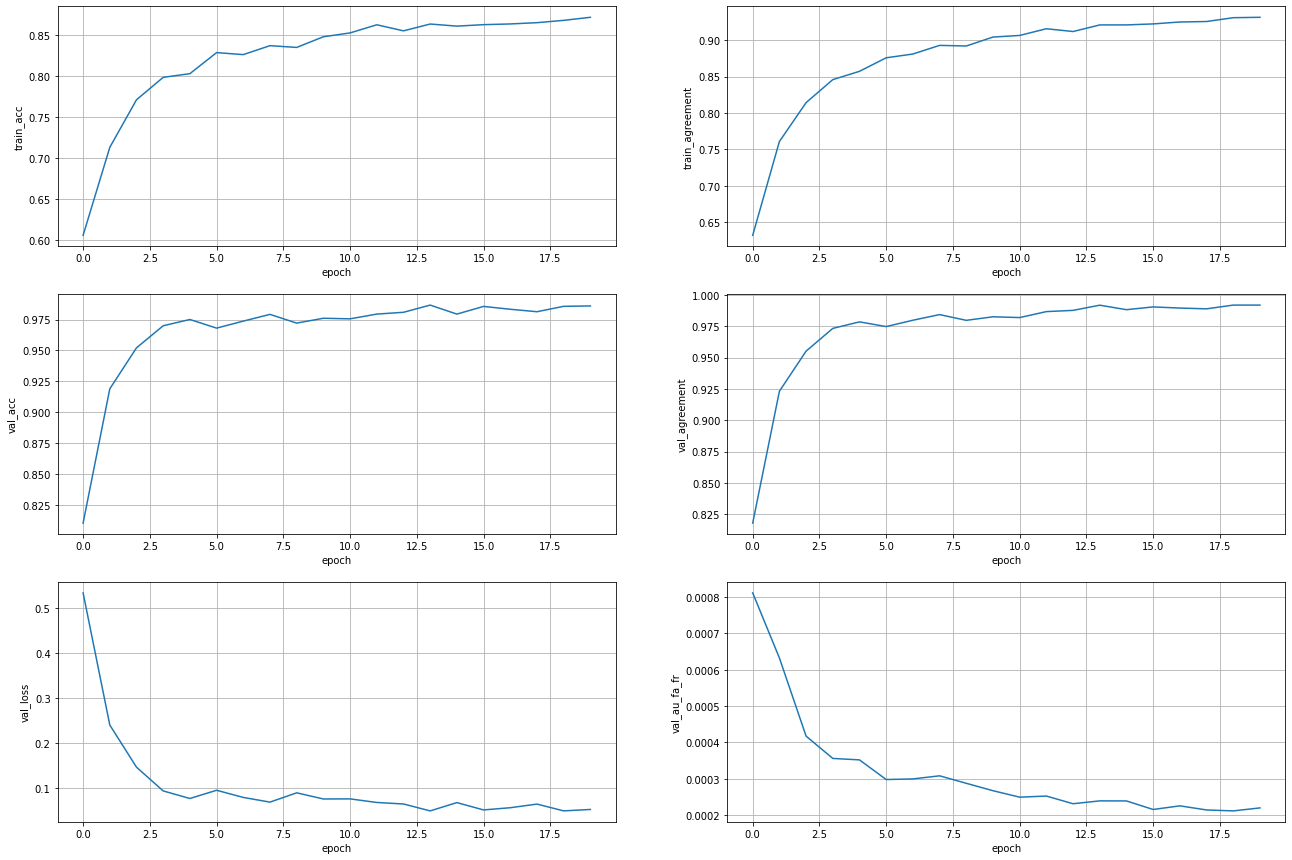

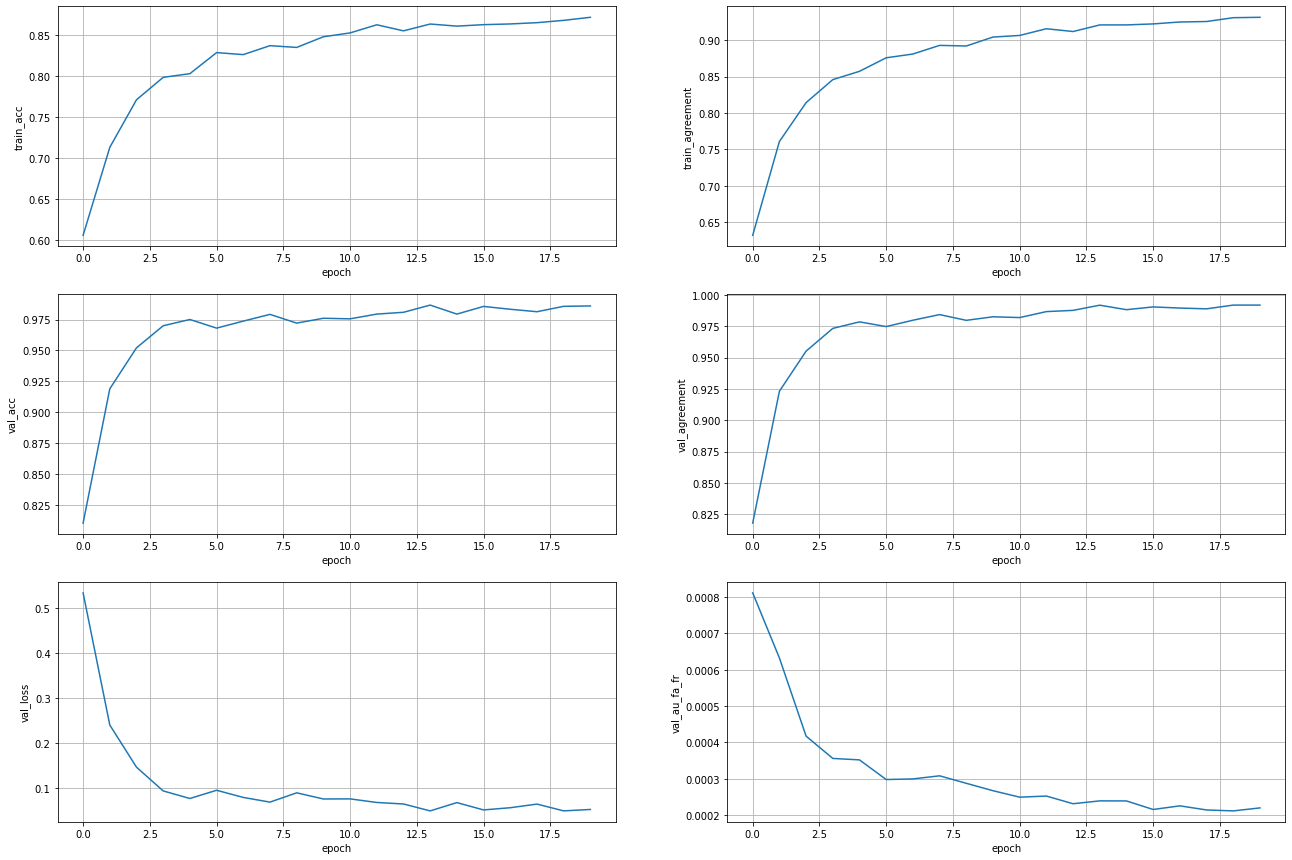

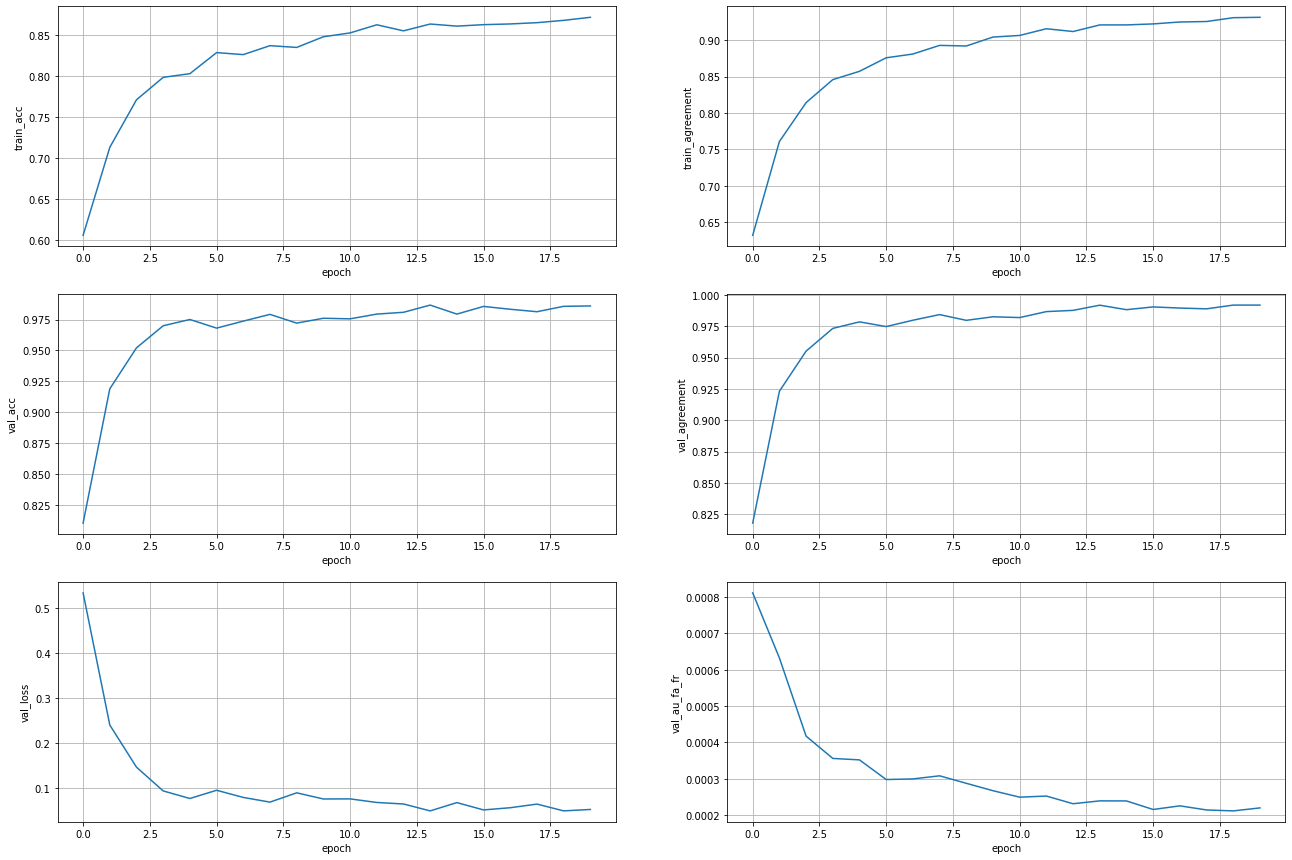

END OF EPOCH 20/20
END OF EPOCH 20/20
END OF EPOCH 20/20


In [57]:
fix_seed(SEED)
config = TaskConfig()
history3_0 = sweep_students(config, ensemble0, [4.0], [0.0], save_fmt='student_exp3-1_{}.pt')
history3_1 = sweep_students(config, ensemble1, [4.0], [0.0], save_fmt='student_exp3-2_{}.pt')
history3_2 = sweep_students(config, ensemble2, [4.0], [0.0], save_fmt='student_exp3-3_{}.pt')

In [58]:
ensemble_metrics = [validation(e, val_loader, melspec_val, config.device) for e in [ensemble0, ensemble1, ensemble2]]

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:850: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:925.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
102it [00:05, 18.05it/s]
102it [00:05, 17.16it/s]
102it [00:06, 16.63it/s]


In [59]:
students_history = [history3_0, history3_1, history3_2]

In [60]:
with open('exp3_metrics.json', 'w') as f:
    json.dump(students_history, f)

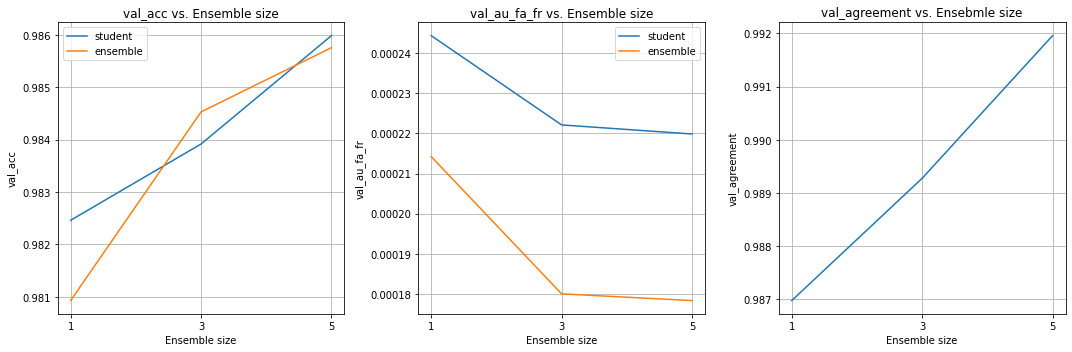

In [64]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

es = [1, 3, 5]

for i, name in enumerate(['val_acc', 'val_au_fa_fr']):
    teacher_vals = [x[name] for x in ensemble_metrics]
    stud_vals = [x[name][-1] for stud_hist in students_history for x in stud_hist]
    axs[i].plot(es, stud_vals, label='student')
    axs[i].plot(es, teacher_vals, label='ensemble')
    axs[i].set_xlabel('Ensemble size')
    axs[i].set_ylabel(name)
    axs[i].set_title(name + ' vs. Ensemble size')
    axs[i].set_xticks(es)
    axs[i].legend()
    axs[i].grid()

axs[-1].plot(es, [x['val_agreement'][-1] for stud_hist in students_history for x in stud_hist], label='student')
axs[-1].set_xlabel('Ensemble size')
axs[-1].set_ylabel('val_agreement')
axs[-1].set_title('val_agreement vs. Ensebmle size')
axs[-1].set_xticks(es)
axs[-1].grid()

plt.tight_layout()
plt.show()

Здесь мы видим результат, схожий со статьей (считаем в нашей задаче метрику AU FA FR более показательной): согласованность растет с увеличением размера ансамбля - по видимому это связано с тем, что в ансамблях распределения более гладкие; качество также коррелирует с согласованностью, но при этом остается промежуток между студентом и ансамблем.

То, что происходит с accuracy, можно назвать странным, но accuracy в нашей задаче не так важен.

# Эксперимент 4. Другой способ дистилляции. 

В рамках этого эксперимента предлагается поменять способ дистилляции, для данной модели удачнее всего сделать дистилляцию attention'а: сводить распределения attention'а моделей.

В этом случае учиться полностью на лоссе дистилляции не получится, поскольку после attention'а есть еще слои, которым тоже нужен сигнал.

Для этого достаточно поменять функцию `train_student_epoch` и `validation`. Учителя возьмем из эксперимента 2.2 (с аугментациями)

In [73]:
def train_student_epoch(student, teacher, optimizer, loader, T=1.0, alpha=0.0):
    student.train()

    accs, agrees = [], []
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(config.device), labels.to(config.device)
        batch = melspec_train(batch)

        optimizer.zero_grad()

        logits, attn_dist = student(batch)
        with torch.no_grad():
            teacher_logits, teacher_attn_dist = teacher(batch)
            teacher_probs = F.softmax(teacher_logits / T, dim=-1)

        probs = F.softmax(logits, dim=-1)
        attn_logits = torch.log(attn_dist)

        hard_loss = F.cross_entropy(logits, labels)
        soft_loss = F.cross_entropy(attn_logits / T, teacher_attn_dist)
        loss = alpha * hard_loss + (1 - alpha) * T * T * soft_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)

        optimizer.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        accs.append((torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)).item())
        agrees.append((torch.sum(argmax_probs == torch.argmax(teacher_probs, dim=-1)) / torch.numel(argmax_probs)).item())

    return {
        'train_acc': np.mean(accs),
        'train_agreement': np.mean(agrees)
    }

@torch.no_grad()
def validation(model, loader, log_melspec, device, teacher=None):
    model.eval()

    val_losses, accs, agrees = [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output, dist = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )

        if teacher is not None:
            # fidelity
            teacher_logits, dist = teacher(batch)
            teacher_pred = torch.argmax(teacher_logits, dim=-1)
            agrees.append(
                torch.sum(argmax_probs == teacher_pred).item() /
                torch.numel(argmax_probs)
            )

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    result = {
        'val_loss': np.mean(val_losses),
        'val_acc': np.mean(accs),
        'val_au_fa_fr': au_fa_fr
    }
    if teacher is not None:
        result['val_agreement'] = np.mean(agrees)
    return result

In [69]:
config = TaskConfig()
teacher3 = CRNN(config, return_attn=True).to(config.device)

teacher3.load_state_dict(torch.load('teacher1.pt'))

<All keys matched successfully>



---



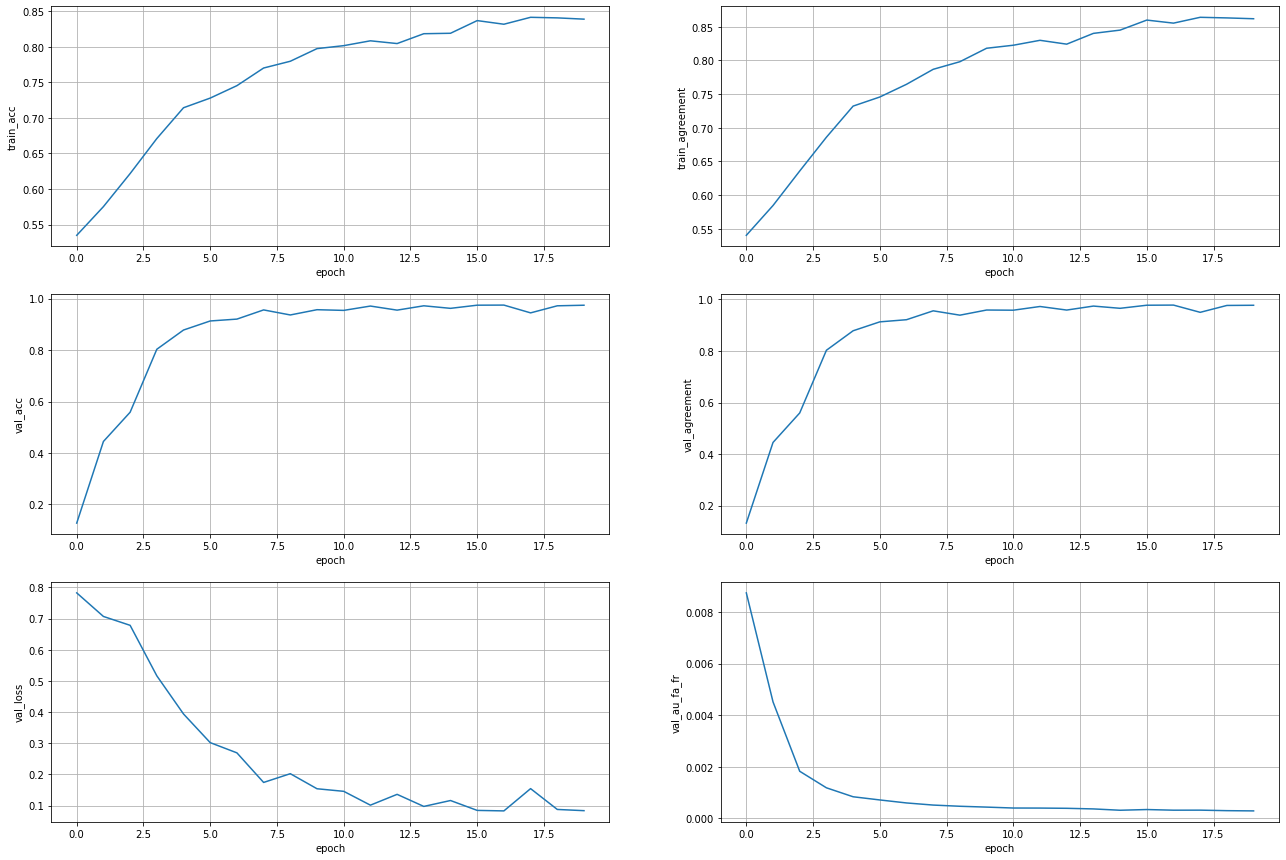

END OF EPOCH 20/20


In [74]:
fix_seed(SEED)

config = TaskConfig()
history4 = sweep_students(config, teacher3, Ts, [0.5], save_fmt='student_exp4_{}.pt', return_attn=True)

In [78]:
with open('exp4_metrics.json', 'w') as f:
    json.dump(history4, f)

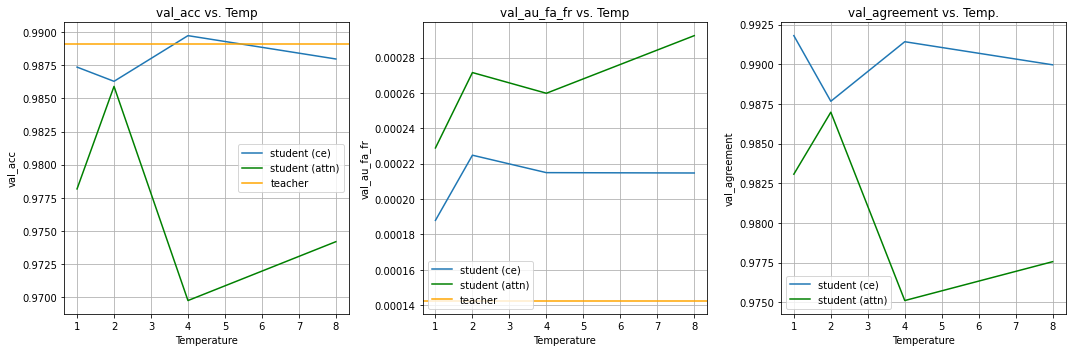

In [77]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

for i, name in enumerate(['val_acc', 'val_au_fa_fr']):
    axs[i].plot(Ts, [x[name][-1] for x in history2_2], label='student (ce)')
    axs[i].plot(Ts, [x[name][-1] for x in history4], label='student (attn)', c='g')
    axs[i].axhline(teacher1_metrics[name], label='teacher', c='orange')
    axs[i].set_xlabel('Temperature')
    axs[i].set_ylabel(name)
    axs[i].set_title(name + ' vs. Temp')
    axs[i].legend()
    axs[i].grid()

axs[-1].plot(Ts, [x['val_agreement'][-1] for x in history2_2], label='student (ce)')
axs[-1].plot(Ts, [x['val_agreement'][-1] for x in history4], label='student (attn)', c='g')
axs[-1].set_xlabel('Temperature')
axs[-1].set_ylabel('val_agreement')
axs[-1].set_title('val_agreement vs. Temp.')
axs[-1].legend()
axs[-1].grid()

plt.tight_layout()
plt.show()

Получилось немного хуже (как по качеству, так и по согласованности), но здесь наблюдается странная зависимость качества (AU FA FR) и согласованности, оня явно отличается от предыдущего варианта дистилляции!